In [100]:
import pyscf
from pyscf import mp, mcscf
import numpy as np
import h5py
import time
import scipy
import itertools
import copy
import matplotlib.pyplot as plt

MACHEPS = 1e-9

In [101]:
def dsrg_HT(F, V, T1, T2, gamma1, eta1, lambda2, lambda3, mf):
    # All three terms for MRPT2/3 are the same, but just involve different F/V
    hc = mf.hc
    ha = mf.ha
    pa = mf.pa
    pv = mf.pv

    # all quantities are stored ^{hh..}_{pp..}
    # h = {c,a}; p = {a, v}

    E = 0.0
    E += 1.000000000 * np.einsum("iu,iv,vu->",F[hc,pa],T1[hc,pa],eta1,optimize="optimal")
    E += -0.500000000 * np.einsum("iu,ixvw,vwux->",F[hc,pa],T2[hc,ha,pa,pa],lambda2,optimize="optimal")
    E += 1.000000000 * np.einsum("ia,ia->",F[hc,pv],T1[hc,pv],optimize="optimal")
    E += 1.000000000 * np.einsum("ua,va,uv->",F[ha,pv],T1[ha,pv],gamma1,optimize="optimal")
    E += -0.500000000 * np.einsum("ua,wxva,uvwx->",F[ha,pv],T2[ha,ha,pa,pv],lambda2,optimize="optimal")
    E += -0.500000000 * np.einsum("iu,ivwx,uvwx->",T1[hc,pa],V[hc,ha,pa,pa],lambda2,optimize="optimal")
    E += -0.500000000 * np.einsum("ua,vwxa,vwux->",T1[ha,pv],V[ha,ha,pa,pv],lambda2,optimize="optimal")
    E += 0.250000000 * np.einsum("ijuv,ijwx,vx,uw->",T2[hc,hc,pa,pa],V[hc,hc,pa,pa],eta1,eta1,optimize="optimal")
    E += 0.125000000 * np.einsum("ijuv,ijwx,uvwx->",T2[hc,hc,pa,pa],V[hc,hc,pa,pa],lambda2,optimize="optimal")
    E += 0.500000000 * np.einsum("iwuv,ixyz,vz,uy,xw->",T2[hc,ha,pa,pa],V[hc,ha,pa,pa],eta1,eta1,gamma1,optimize="optimal")
    E += 1.000000000 * np.einsum("iwuv,ixyz,vz,uxwy->",T2[hc,ha,pa,pa],V[hc,ha,pa,pa],eta1,lambda2,optimize="optimal")
    E += 0.250000000 * np.einsum("iwuv,ixyz,xw,uvyz->",T2[hc,ha,pa,pa],V[hc,ha,pa,pa],gamma1,lambda2,optimize="optimal")
    E += 0.250000000 * np.einsum("iwuv,ixyz,uvxwyz->",T2[hc,ha,pa,pa],V[hc,ha,pa,pa],lambda3,optimize="optimal")
    E += 0.500000000 * np.einsum("ijua,ijva,uv->",T2[hc,hc,pa,pv],V[hc,hc,pa,pv],eta1,optimize="optimal")
    E += 1.000000000 * np.einsum("ivua,iwxa,ux,wv->",T2[hc,ha,pa,pv],V[hc,ha,pa,pv],eta1,gamma1,optimize="optimal")
    E += 1.000000000 * np.einsum("ivua,iwxa,uwvx->",T2[hc,ha,pa,pv],V[hc,ha,pa,pv],lambda2,optimize="optimal")
    E += 0.500000000 * np.einsum("vwua,xyza,uz,yw,xv->",T2[ha,ha,pa,pv],V[ha,ha,pa,pv],eta1,gamma1,gamma1,optimize="optimal")
    E += 0.250000000 * np.einsum("vwua,xyza,uz,xyvw->",T2[ha,ha,pa,pv],V[ha,ha,pa,pv],eta1,lambda2,optimize="optimal")
    E += 1.000000000 * np.einsum("vwua,xyza,yw,uxvz->",T2[ha,ha,pa,pv],V[ha,ha,pa,pv],gamma1,lambda2,optimize="optimal")
    E += -0.250000000 * np.einsum("vwua,xyza,uxyvwz->",T2[ha,ha,pa,pv],V[ha,ha,pa,pv],lambda3,optimize="optimal")
    E += 0.250000000 * np.einsum("ijab,ijab->",T2[hc,hc,pv,pv],V[hc,hc,pv,pv],optimize="optimal")
    E += 0.500000000 * np.einsum("iuab,ivab,vu->",T2[hc,ha,pv,pv],V[hc,ha,pv,pv],gamma1,optimize="optimal")
    E += 0.250000000 * np.einsum("uvab,wxab,xv,wu->",T2[ha,ha,pv,pv],V[ha,ha,pv,pv],gamma1,gamma1,optimize="optimal")
    E += 0.125000000 * np.einsum("uvab,wxab,wxuv->",T2[ha,ha,pv,pv],V[ha,ha,pv,pv],lambda2,optimize="optimal")
    return E

def regularized_denominator(x, s):
    if abs(x) <= MACHEPS:
        return 0.0
    return (1. - np.exp(-s * x**2)) / x

def one_plus_exp_s(x):
    return 1. + np.exp(-s * x * x)

def exp_s(x):
    return np.exp(-s * x * x)

def set_bit(bit_loc):
    """
    Set the bit_loc-th bit in bit string f. Returns unchanged if the bit is already set. bit_loc is zero-indexed.
    """
    f = 0
    for loc in bit_loc:
        f = f | 1<<loc
    return f

def set_bit_single(f, bit_loc):
    """
    Set the bit_loc-th bit in bit string f. Returns unchanged if the bit is already set. bit_loc is zero-indexed.
    """
    return f | 1<<bit_loc

def clear_bit(f, bit_loc):
    """
    Unset the bit_loc-th bit in bit string f. Returns unchanged if the bit is already unset. bit_loc is zero-indexed.
    """
    return f & ~(1<<bit_loc)

def test_bit(f, bit_loc):
    """
    Test if bit_loc in f is set. Returns 1 if set, 0 if not set.
    """
    return (f & (1<<bit_loc)) >> bit_loc


def count_set_bits(f):
    """
    Return the number of set (1) bits in the bit string f.
    """
    return int(bin(f).count('1'))

def get_excitation_level(f1, f2):
    """
    Get the excitation level between two bit strings f1 and f2, i.e., half the Hamming distance.
    """
    return int(count_set_bits(f1^f2)/2)

def test_bit(f, bit_loc):
    """
    Test if bit_loc in f is set. Returns 1 if set, 0 if not set.
    """
    return (f & (1<<bit_loc)) >> bit_loc

def annop(bit_string, ispinor):
        """
        Annihilation operator, annihilates spinorb in bit_string, returns the sign and the resulting bit string.
        If spinorb is already empty, sign is zero and the bit string is returned unchanged.
        """
        if (not test_bit(bit_string, ispinor)):
            sgn = 0
        else:
            test_string = 0
            for i in range(ispinor):
                test_string = set_bit_single(test_string, i)
            sgn = (-1)**(count_set_bits(bit_string & test_string))
            bit_string = clear_bit(bit_string, ispinor)
        return (sgn, bit_string)
    
def bstring_to_occ_vec(f, nelec, norbs):
    occ_vec = np.zeros(nelec, dtype='int')
    nfound = 0
    for i in range(norbs):
        if test_bit(f, i)==1:
            occ_vec[nfound] = i
            nfound += 1
            if (nfound==nelec):
                break
    return occ_vec

def get_excit_connection(f1, f2, exlvl, nelec, norbs):
    excit_bstring = f1^f2
    
    excit = np.zeros((2,exlvl), dtype='int')
    nbit_f1_found = 0
    nbit_f2_found = 0
    for i in range(norbs):
        if (test_bit(excit_bstring, i)==1):
            # Check where this electron is coming from / going to
            if (test_bit(f1, i)):
                excit[0][nbit_f1_found] = i
                nbit_f1_found += 1
            else:
                excit[1][nbit_f2_found] = i
                nbit_f2_found += 1
            if (nbit_f1_found == exlvl and nbit_f2_found==exlvl):
                break
                
    # Get permutation!
    perm = annop_mult(f1, excit[0])[0] * annop_mult(f2, excit[1])[0]

    return excit, perm

def annop_mult(f, orbs):
    fold = f
    perm = 1
    for orb in orbs:
        iperm, fnew = annop(fold, orb)
        perm *= iperm
        fold = fnew
    
    return perm, fnew

def make_cumulants(rdm):
    try:
        assert rdm['max_rdm_level'] >= 2
    except AssertionError:
        raise Exception('Max RDM level is 1, cumulants not necessary!')
        
    _lamb = {'max_cumulant_level':rdm['max_rdm_level']}
    _lamb['gamma1'] = rdm['1rdm']
    _lamb['eta1'] = -rdm['1rdm'] + np.diag(np.zeros(rdm['1rdm'].shape[0])+1)
    _lamb['lambda2'] = rdm['2rdm'] - np.einsum('pr,qs->pqrs', rdm['1rdm'], rdm['1rdm']) + np.einsum('ps,qr->pqrs', rdm['1rdm'], rdm['1rdm'])
    if (rdm['max_rdm_level'] == 3):
        _lamb['lambda3'] = rdm['3rdm'] - np.einsum('ps,qrtu->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('pt,qrsu->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('pu,qrts->pqrstu',rdm['1rdm'],rdm['2rdm'])- np.einsum('qt,prsu->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('qs,prtu->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('qu,prst->pqrstu',rdm['1rdm'],rdm['2rdm'])- np.einsum('ru,pqst->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('rs,pqut->pqrstu',rdm['1rdm'],rdm['2rdm']) + np.einsum('rt,pqsu->pqrstu',rdm['1rdm'],rdm['2rdm'])+ 2*(np.einsum('ps,qt,ru->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']) + np.einsum('pt,qu,rs->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']) + np.einsum('pu,qs,rt->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']))- 2*(np.einsum('ps,qu,rt->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']) + np.einsum('pu,qt,rs->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']) + np.einsum('pt,qs,ru->pqrstu',rdm['1rdm'],rdm['1rdm'],rdm['1rdm']))
                
    return _lamb

In [237]:
class mySCF:
    def __init__(self, mol, c0=None, verbose=True):
        self.mol = mol
        self.nuclear_repulsion = self.mol.energy_nuc()
        self.nelec = sum(self.mol.nelec)
        self.nocc = self.nelec
        self.nlrg = self.mol.nao*2
        self.nvirtual = self.nlrg - self.nocc
        self.verbose = verbose
        if (c0 is None):
            self.c0 = pyscf.lib.param.LIGHT_SPEED
        else:
            self.c0 = c0
            #pyscf.lib.param.LIGHT_SPEED = c0
        
    def run_rhf(self, build_spinorb_ints=False, density_fitting=False):
        if (density_fitting):
            if (self.verbose): print('Enabling density fitting!')
            self.rhf = pyscf.scf.RHF(self.mol).density_fit()
        else:
            self.rhf = pyscf.scf.RHF(self.mol)

        self.rhf_energy = self.rhf.kernel()

        if (self.verbose): print(f"Non-relativistic RHF Energy: {self.rhf_energy:15.7f} Eh")

        try:
            assert (not (build_spinorb_ints and density_fitting))
        except AssertionError:
            raise Exception("Can't rebuild RHF integrals with density fitting on at the moment!")
        
        if (build_spinorb_ints):
            self.rhf_hcore_ao = self.mol.intor_symmetric('int1e_kin') + self.mol.intor_symmetric('int1e_nuc')
            self.rhf_hcore_mo = np.einsum('pi,pq,qj->ij', self.rhf.mo_coeff, self.rhf_hcore_ao, self.rhf.mo_coeff)

            self.rhf_eri_ao = self.mol.intor('int2e_sph') # Chemist's notation (ij|kl)
            self.rhf_eri_mo = pyscf.ao2mo.incore.full(self.rhf_eri_ao, self.rhf.mo_coeff)
            _rhf_eri_spatorb = self.rhf_eri_mo.swapaxes(1,2)

            self.nspinorb = self.mol.nao*2

            self.rhf_hcore_spinorb = np.zeros((self.nspinorb,self.nspinorb),dtype='float64') # Interleaved 1a1b 2a2b 3a3b ....
            self.rhf_hcore_spinorb[::2,::2] = self.rhf_hcore_spinorb[1::2,1::2] = self.rhf_hcore_mo

            self.rhf_eri_full_asym = np.zeros((self.nspinorb,self.nspinorb,self.nspinorb,self.nspinorb),dtype='float64') # Interleaved 1a1b 2a2b 3a3b ....
            self.rhf_eri_full_asym[::2,::2,::2,::2] = self.rhf_eri_full_asym[1::2,1::2,1::2,1::2] = _rhf_eri_spatorb - _rhf_eri_spatorb.swapaxes(2,3) # <aa||aa> and <bb||bb>
            self.rhf_eri_full_asym[::2,1::2,::2,1::2] = self.rhf_eri_full_asym[1::2,::2,1::2,::2] = _rhf_eri_spatorb # <ab||ab> = <ba||ba> = <ab|ab>
            self.rhf_eri_full_asym[::2,1::2,1::2,::2] = self.rhf_eri_full_asym[1::2,::2,::2,1::2] = -_rhf_eri_spatorb.swapaxes(2,3) # <ab||ba> = <ba||ab> = -<ab|ab>
        
    def run_dhf(self, transform=False, debug=False, frozen=None, with_gaunt=False, with_breit=False, with_ssss=True, density_fitting=False):
        # Run relativistic Dirac-Hartree-Fock
        if (density_fitting):
            if (self.verbose): print('Enabling density fitting!')
            self.dhf = pyscf.scf.DHF(self.mol).density_fit()
        else:
            self.dhf = pyscf.scf.DHF(self.mol)

        self.dhf.with_gaunt = with_gaunt
        self.dhf.with_breit = with_breit
        self.dhf.with_ssss = with_ssss
        self.dhf_energy = self.dhf.kernel()
        if (self.verbose): print(f"Relativistic DHF Energy:     {self.dhf_energy:15.7f} Eh")

        if (transform):
            _t0 = time.time()
            self.norb = len(self.dhf.mo_energy)

            # Harvest h from DHF (Includes both S & L blocks)
            _dhf_hcore_ao = self.dhf.get_hcore()
            _dhf_hcore_mo = np.einsum('pi,pq,qj->ij', np.conjugate(self.dhf.mo_coeff[:,self.nlrg:]), _dhf_hcore_ao, self.dhf.mo_coeff[:,self.nlrg:])

            del _dhf_hcore_ao

            if (frozen == 0 or frozen == (0,0)):
                frozen = None

            if (frozen is not None):
                try:
                    assert (type(frozen) is int or type(frozen) is tuple) # [todo]: We should allow freezing virtuals too..
                    if (type(frozen) is int):
                        assert (frozen >= 0 and frozen < self.nelec)
                    else:
                        assert ((frozen[0] >= 0 and frozen[0] < self.nelec) and frozen[1] <= self.nvirtual)
                except AssertionError:
                    raise Exception("The 'frozen' argument must be an integer or tuple of integers, and they have to fit into the spectrum!")
                
                
                if (type(frozen) is int):
                    self.nfrozen = frozen
                    self.nfrozen_virt = 0
                else:
                    self.nfrozen = frozen[0]
                    self.nfrozen_virt = frozen[1]
                _nlrg = self.nlrg # We need to preserve the original nlrg for just a little bit longer..
                self.nlrg -= (self.nfrozen + self.nfrozen_virt)
                
                self.nelec -= self.nfrozen
                self.nocc -= self.nfrozen
                self.nvirtual -= self.nfrozen_virt

                _frzc = slice(0,self.nfrozen)
                _actv = slice(self.nfrozen,self.nlrg+self.nfrozen)

                self.e_frozen = np.einsum('ii->',_dhf_hcore_mo[_frzc,_frzc]) # The 1e part is common to both with DF and without, the 2e part is done later
            else:
                self.nfrozen = 0
                self.e_frozen = 0.0
                self.dhf_hcore_mo = _dhf_hcore_mo
                _frzc = slice(0,self.nfrozen)
                _actv = slice(self.nfrozen,self.nlrg+self.nfrozen)
                _nlrg = self.nlrg


            if (density_fitting):
                self.naux = self.dhf.with_df._cderi[0].shape[0]
                _mem = 2*(self.naux*self.nlrg**2)*16/1e9
                if (_mem < 1.0):
                    if (self.verbose): print(f'Will now allocate {_mem*1000:.3f} MB memory for the DF AO ERI tensor!')
                else:
                    if (self.verbose): print(f'Will now allocate {_mem:.3f} GB memory for the DF AO ERI tensor!')

                _Lpq_LL = pyscf.lib.unpack_tril(self.dhf.with_df._cderi[0]) # 0 is eri_LL, 1 is eri_SS
                _Lpq_SS = pyscf.lib.unpack_tril(self.dhf.with_df._cderi[1])/(2*pyscf.lib.param.LIGHT_SPEED)**2 # 0 is eri_LL, 1 is eri_SS

                _Lpq_mo_LL = np.einsum('ip,jq,lij->lpq',np.conjugate(self.dhf.mo_coeff[:_nlrg,_nlrg:]),self.dhf.mo_coeff[:_nlrg,_nlrg:],_Lpq_LL,optimize='optimal')
                _Lpq_mo_SS = np.einsum('ip,jq,lij->lpq',np.conjugate(self.dhf.mo_coeff[_nlrg:,_nlrg:]),self.dhf.mo_coeff[_nlrg:,_nlrg:],_Lpq_SS,optimize='optimal')
                del _Lpq_LL, _Lpq_SS

                _t1 = time.time()

                if (frozen is not None):
                    # The 2e part of e_frozen
                    self.e_frozen += 0.5*(np.einsum('lii,ljj->',_Lpq_mo_LL[:,_frzc,_frzc],_Lpq_mo_LL[:,_frzc,_frzc])+np.einsum('lii,ljj->',_Lpq_mo_SS[:,_frzc,_frzc],_Lpq_mo_SS[:,_frzc,_frzc])+np.einsum('lii,ljj->',_Lpq_mo_SS[:,_frzc,_frzc],_Lpq_mo_LL[:,_frzc,_frzc])+np.einsum('lii,ljj->',_Lpq_mo_LL[:,_frzc,_frzc],_Lpq_mo_SS[:,_frzc,_frzc]))
                    self.e_frozen -= 0.5*(np.einsum('lij,lji->',_Lpq_mo_LL[:,_frzc,_frzc],_Lpq_mo_LL[:,_frzc,_frzc])+np.einsum('lij,lji->',_Lpq_mo_SS[:,_frzc,_frzc],_Lpq_mo_SS[:,_frzc,_frzc])+np.einsum('lij,lji->',_Lpq_mo_SS[:,_frzc,_frzc],_Lpq_mo_LL[:,_frzc,_frzc])+np.einsum('lij,lji->',_Lpq_mo_LL[:,_frzc,_frzc],_Lpq_mo_SS[:,_frzc,_frzc]))
                    
                    self.dhf_hcore_mo = _dhf_hcore_mo[_actv,_actv].copy()
                    del _dhf_hcore_mo
                    self.dhf_hcore_mo += np.einsum('lpq,lii->pq',_Lpq_mo_LL[:,_actv,_actv],_Lpq_mo_LL[:,:self.nfrozen,:self.nfrozen])+np.einsum('lpq,lii->pq',_Lpq_mo_SS[:,_actv,_actv],_Lpq_mo_SS[:,:self.nfrozen,:self.nfrozen])+np.einsum('lpq,lii->pq',_Lpq_mo_SS[:,_actv,_actv],_Lpq_mo_LL[:,:self.nfrozen,:self.nfrozen])+np.einsum('lpq,lii->pq',_Lpq_mo_LL[:,_actv,_actv],_Lpq_mo_SS[:,:self.nfrozen,:self.nfrozen])
                    self.dhf_hcore_mo -= np.einsum('lpi,liq->pq',_Lpq_mo_LL[:,_actv,_frzc],_Lpq_mo_LL[:,_frzc,_actv])+np.einsum('lpi,liq->pq',_Lpq_mo_SS[:,_actv,_frzc],_Lpq_mo_SS[:,_frzc,_actv])+np.einsum('lpi,liq->pq',_Lpq_mo_SS[:,_actv,_frzc],_Lpq_mo_LL[:,_frzc,_actv])+np.einsum('lpi,liq->pq',_Lpq_mo_LL[:,_actv,_frzc],_Lpq_mo_SS[:,_frzc,_actv])


                _mem = (self.nlrg**4)*16/1e9
                if (_mem < 1.0):
                    if (self.verbose): print(f'Will now allocate {_mem*1000:.3f} MB memory for the MO ERI tensor!')
                else:
                    if (self.verbose): print(f'Will now allocate {_mem:.3f} GB memory for the MO ERI tensor!')

                self.dhf_eri_full_asym = np.einsum('lpq,lrs->pqrs',_Lpq_mo_LL[:,_actv,_actv],_Lpq_mo_LL[:,_actv,_actv],optimize='optimal') + np.einsum('lpq,lrs->pqrs',_Lpq_mo_SS[:,_actv,_actv],_Lpq_mo_SS[:,_actv,_actv],optimize='optimal') + np.einsum('lpq,lrs->pqrs',_Lpq_mo_LL[:,_actv,_actv],_Lpq_mo_SS[:,_actv,_actv],optimize='optimal') + np.einsum('lpq,lrs->pqrs',_Lpq_mo_SS[:,_actv,_actv],_Lpq_mo_LL[:,_actv,_actv],optimize='optimal')
                del _Lpq_mo_LL, _Lpq_mo_SS
                self.dhf_eri_full_asym = self.dhf_eri_full_asym.swapaxes(1,2) - self.dhf_eri_full_asym.swapaxes(1,2).swapaxes(2,3)
                _t2 = time.time()
            else:
                _dhf_eri_ao_SSLL = self.mol.intor('int2e_spsp1_spinor')/(2*self.c0)**2 # kinetic balance

                _mem = self.norb**4*16/1e9
                if (_mem < 1.0):
                    if (self.verbose): print(f'Will now allocate {_mem*1000:.3f} MB memory for the AO ERI tensor!')
                else:
                    if (self.verbose): print(f'Will now allocate {_mem:.3f} GB memory for the AO ERI tensor!')
            

                _dhf_eri_ao = np.zeros((self.norb,self.norb,self.norb,self.norb),dtype='complex128')
                _dhf_eri_ao[_nlrg:,_nlrg:,_nlrg:,_nlrg:] = self.mol.intor('int2e_spsp1spsp2_spinor')/(2*self.c0)**4
                _dhf_eri_ao[:_nlrg,:_nlrg,:_nlrg,:_nlrg] = self.mol.intor('int2e_spinor')
                _dhf_eri_ao[_nlrg:,_nlrg:,:_nlrg,:_nlrg] = _dhf_eri_ao_SSLL
                _dhf_eri_ao[:_nlrg,:_nlrg,_nlrg:,_nlrg:] = (_dhf_eri_ao_SSLL.swapaxes(0,2).swapaxes(1,3)) # No need to conjugate as we're using Chemist's notation

                del _dhf_eri_ao_SSLL

                _t1 = time.time()
                
                _dhf_eri_mo_full = np.einsum('pi,qj,pqrs,rk,sl->ijkl',np.conjugate(self.dhf.mo_coeff[:,_nlrg:]),(self.dhf.mo_coeff[:,_nlrg:]),_dhf_eri_ao,np.conjugate(self.dhf.mo_coeff[:,_nlrg:]),(self.dhf.mo_coeff[:,_nlrg:]),optimize=True)
                _dhf_eri_full_asym = _dhf_eri_mo_full.swapaxes(1,2) - _dhf_eri_mo_full.swapaxes(1,2).swapaxes(2,3)

                del _dhf_eri_ao, _dhf_eri_mo_full

                _t2 = time.time()
                
                if (frozen is not None):
                    self.e_frozen += 0.5*np.einsum('ijij->',_dhf_eri_full_asym[:self.nfrozen,:self.nfrozen,:self.nfrozen,:self.nfrozen])

                    self.dhf_hcore_mo = _dhf_hcore_mo[_actv, _actv].copy() + np.einsum('ipjp->ij',_dhf_eri_full_asym[_actv,_frzc,_actv,_frzc])
                    del _dhf_hcore_mo
                    self.dhf_eri_full_asym = _dhf_eri_full_asym[_actv,_actv,_actv,_actv]
                    del _dhf_eri_full_asym
                else:
                    self.e_frozen = 0.0
                    self.dhf_eri_full_asym = _dhf_eri_full_asym
                    self.dhf_hcore_mo = _dhf_hcore_mo

            self.nuclear_repulsion += self.e_frozen
            
            self.dhf_e1 = np.einsum('ii->',self.dhf_hcore_mo[:self.nocc, :self.nocc])
            self.dhf_e2 = 0.5*np.einsum('ijij->',self.dhf_eri_full_asym[:self.nocc, :self.nocc, :self.nocc, :self.nocc])            
            self.dhf_e_rebuilt = self.dhf_e1 + self.dhf_e2 + self.nuclear_repulsion
            if (debug and self.verbose):
                print(f"Rebuilt DHF Energy:          {self.dhf_e_rebuilt.real:15.7f} Eh")
                print(f"Diff:           {np.abs(self.dhf_e_rebuilt.real - self.dhf_energy):.6e}")
                if (frozen is None):
                    print(f"Diff 1e:        {np.abs(self.dhf.scf_summary['e1']-self.dhf_e1):.6e}")
                    print(f"Diff 2e:        {np.abs(self.dhf.scf_summary['e2']-self.dhf_e2):.6e}")
            
            _t3 = time.time()
            
            if (self.verbose):
                print(f'\nTiming report')
                print(f'....integral retrieval:      {(_t1-_t0):15.7f} s')
                print(f'....integral transformation: {(_t2-_t1):15.7f} s')
                print(f'....integral contractions:   {(_t3-_t2):15.7f} s')
                print(f'Total time taken:            {(_t3-_t0):15.7f} s\n')
    
    def run_mp2(self, relativistic=True):
        if (relativistic):
            _hcore = self.dhf_hcore_mo
            _eri = self.dhf_eri_full_asym
            _method = 'Relativistic'
            _e_scf = self.dhf_e_rebuilt
        else:
            _hcore = self.rhf_hcore_spinorb
            _eri = self.rhf_eri_full_asym
            _method = 'Non-relativistic'
            _e_scf = self.rhf_energy
            
        _t0 = time.time()
        _upq = np.einsum('piqi->pq',_eri[:,:self.nocc,:,:self.nocc])
        self.fock_mo = _upq + _hcore

        self.D2 = np.zeros((self.nocc,self.nocc,self.nvirtual,self.nvirtual))
        _e = np.diag(self.fock_mo)
        for i in range(self.nocc):
            for j in range(self.nocc):
                for a in range(self.nvirtual):
                    for b in range(self.nvirtual):
                        self.D2[i,j,a,b] = -1./((_e[a+self.nocc] + _e[b+self.nocc] - _e[i] - _e[j]).real)

        _oovv = _eri[:self.nocc,:self.nocc,self.nocc:,self.nocc:]
        _vvoo = _eri[self.nocc:,self.nocc:,:self.nocc,:self.nocc]

        self.e_mp2 = 0.25*np.einsum('ijab,ijab,abij->',_oovv,self.D2,_vvoo)

        try:
            assert(abs(self.e_mp2.imag) < MACHEPS)
        except AssertionError:
            print(f'Imaginary part of MP2 energy is larger than {MACHEPS}')
        
        self.e_mp2 = self.e_mp2.real

        _t1 = time.time()
        if (self.verbose):
            print(f'{_method} MP2 Ecorr:      {self.e_mp2.real:15.7f} Eh')
            print(f'{_method} MP2 Energy:     {(self.e_mp2 + _e_scf).real:15.7f} Eh')
            print(f'Time taken:                  {(_t1-_t0):15.7f} s\n')
        if (not relativistic):
            self.nonrel_mp2 = pyscf.mp.MP2(self.rhf)
            _e_mp2 = self.nonrel_mp2.kernel()[0]
            if (self.verbose): print(f'Error to PySCF:   {(self.e_mp2-_e_mp2):15.7f} Eh')
        
    def run_casci(self, cas=None, do_fci=False, rdm_level=0, relativistic=True, semi_canonicalize=True):
        try:
            assert ((cas is None) and do_fci) or ((cas is not None) and (not do_fci))
        except AssertionError:
            raise Exception("If not doing FCI then a CAS must be provided via the 'cas' argument!")
            
        if cas is not None:
            try:
                assert type(cas) is tuple
            except AssertionError:
                raise Exception("'cas' must be a tuple of two integers!")
                
            try:
                assert int(cas[0]) <= int(cas[1])
            except AssertionError:
                raise Exception("Number of CAS electrons must be <= number of CAS spinors!")

        _t0 = time.time()
        
        
        if do_fci:
            _norbs = self.nlrg
            _nelec = self.nelec
            _ncoreel = 0
        else:
            _nelec, _norbs = cas
            _ncoreel = self.nelec-_nelec
            
        self.cas = (_nelec,_norbs)
        
        self.ncore = _ncoreel
        self.nact = _norbs
        self.nvirt = self.nlrg-(self.ncore+self.nact) # This is different from nvirtual, which is in the single-reference sense (nvirt in the HF reference)
        self.nhole = self.ncore+self.nact
        self.npart = self.nact+self.nvirt
        
        self.core = slice(0,_ncoreel)
        self.active = slice(_ncoreel, _ncoreel+_norbs)
        self.virt = slice(_ncoreel+_norbs, self.nlrg)
        self.hole = slice(0,_ncoreel+_norbs)
        self.part = slice(_ncoreel, self.nlrg)
        
        self.hc = self.core
        self.ha = self.active
        self.pa = slice(0,self.nact)
        self.pv = slice(self.nact,self.nlrg)

        self.e_casci_frzc = 0.0
            
        if (relativistic):
            _hcore = self.dhf_hcore_mo
            _eri = self.dhf_eri_full_asym
            _method = 'Relativistic'
            _e_scf = self.dhf_e_rebuilt
        else:
            _hcore = self.rhf_hcore_spinorb
            _eri = self.rhf_eri_full_asym
            _method = 'Non-relativistic'
            _e_scf = self.rhf_energy
            
        if (self.ncore != 0):
            self.e_casci_frzc = np.einsum('ii->',_hcore[self.core,self.core]) + 0.5*np.einsum('ijij->',_eri[self.core,self.core,self.core,self.core])
            _hcore_frzc_cas = _hcore[self.part, self.part].copy() + np.einsum('ipjp->ij',_eri[self.part,self.core,self.part,self.core])
            _hcore_cas = _hcore_frzc_cas
        else:
            _hcore_cas = _hcore
            
        self.ncombs = scipy.special.comb(_norbs, _nelec, exact=True)
        self.det_strings = list(map(set_bit, list(itertools.combinations(range(_norbs),_nelec))))

        assert(len(self.det_strings) == self.ncombs)
        
        self.hamil_det = np.zeros((self.ncombs,self.ncombs), dtype='complex128')
        for i in range(self.ncombs):
            for j in range(i+1):
                exlvl = get_excitation_level(self.det_strings[i], self.det_strings[j])
                if (exlvl <= 2):
                    if (i==j):
                        occ = bstring_to_occ_vec(self.det_strings[i], *self.cas)
                        self.hamil_det[i,i] = 0
                        for iocc in occ:
                            self.hamil_det[i,i] += _hcore_cas[iocc,iocc]
                            for jocc in occ:
                                self.hamil_det[i,i] += 0.5*_eri[iocc+self.ncore,jocc+self.ncore,iocc+self.ncore,jocc+self.ncore]
                    elif (exlvl == 1):
                        occ = bstring_to_occ_vec(self.det_strings[i], *self.cas)
                        conn, perm = get_excit_connection(self.det_strings[i], self.det_strings[j], exlvl, *self.cas)
                        self.hamil_det[i,j] = _hcore_cas[conn[0],conn[1]]
                        for iocc in occ:
                            self.hamil_det[i,j] += _eri[conn[0]+self.ncore, iocc+self.ncore, conn[1]+self.ncore, iocc+self.ncore]

                        self.hamil_det[i,j] *= perm
                        self.hamil_det[j,i] = np.conjugate(self.hamil_det[i,j])
                    elif (exlvl == 2):
                        conn, perm = get_excit_connection(self.det_strings[i], self.det_strings[j], exlvl, *self.cas)
                        self.hamil_det[i,j] = perm*_eri[conn[0][0]+self.ncore, conn[0][1]+self.ncore, conn[1][0]+self.ncore, conn[1][1]+self.ncore]
                        self.hamil_det[j,i] = np.conjugate(self.hamil_det[i,j])         
        _t1 = time.time()
        
        self.casci_eigvals, self.casci_eigvecs = np.linalg.eigh(self.hamil_det)
        #self.fci_eigvals += self.nuclear_repulsion
        _t2 = time.time()
                
        if (rdm_level>0):
            try:
                assert rdm_level <= 3
            except AssertionError:
                raise Exception("RDM level up to 3 supported!")
                
            _rdms = {'max_rdm_level':rdm_level}
            if (rdm_level>=1):
                _psi = self.casci_eigvecs[:,0]
                _rdms['1rdm'] = self.get_1_rdm(self.cas, _psi)
                _gen_fock_canon = _hcore.copy() + np.einsum('piqi->pq',_eri[:,self.core,:,self.core]) + np.einsum('piqj,ij->pq',_eri[:,self.active,:,self.active],_rdms['1rdm'])
                self.fock = _gen_fock_canon
                if (semi_canonicalize):
                    _gen_fock_diag = np.zeros_like(_gen_fock_canon)
                    _gen_fock_diag[self.core,self.core] = _gen_fock_canon[self.core,self.core]
                    _gen_fock_diag[self.active,self.active] = _gen_fock_canon[self.active,self.active]
                    _gen_fock_diag[self.virt,self.virt] = _gen_fock_canon[self.virt,self.virt]
                    _, self.semicanonicalizer = np.linalg.eigh(_gen_fock_diag)
                    self.gen_fock_semicanon = np.einsum('ip,ij,jq->pq',np.conjugate(self.semicanonicalizer), _gen_fock_canon, self.semicanonicalizer)
                    self.fock = self.gen_fock_semicanon
                    self.semicanonicalizer_active = self.semicanonicalizer[self.active, self.active]
            if (rdm_level>=2):
                if (_nelec>=2):
                    _rdms['2rdm'] = self.get_2_rdm(self.cas, _psi)
                else:
                    _rdms['2rdm'] = np.zeros((self.cas[1],self.cas[1],self.cas[1],self.cas[1]), dtype='complex128')
            if (rdm_level>=3):
                if (_nelec>=3):
                    _rdms['3rdm'] = self.get_3_rdm(self.cas, _psi)
                else:
                    _rdms['3rdm'] = np.zeros((self.cas[1],self.cas[1],self.cas[1],self.cas[1],self.cas[1],self.cas[1]), dtype='complex128')
               
            if (semi_canonicalize):
                # a_p+~ = a_q+ U _qp
                # a_p ~ = a_q  U*_qp
                # <a_p+~ a_q~> = <a_i+ U_ip a_j U*_jq> = U_ip gamma_ij U*_jq
                # cf. Helgaker Ch. 3.2
                if (rdm_level>=1): _rdms['1rdm'] = np.einsum('ip,ij,jq->pq', self.semicanonicalizer_active, _rdms['1rdm'], np.conjugate(self.semicanonicalizer_active), optimize='optimal')
                if (rdm_level>=2): _rdms['2rdm'] = np.einsum('ip,jq,ijkl,kr,ls->pqrs', self.semicanonicalizer_active, self.semicanonicalizer_active, _rdms['2rdm'], np.conjugate(self.semicanonicalizer_active),np.conjugate(self.semicanonicalizer_active), optimize='optimal')
                if (rdm_level>=3): _rdms['3rdm'] = np.einsum('ip,jq,kr,ijklmn,ls,mt,nu->pqrstu', self.semicanonicalizer_active, self.semicanonicalizer_active, self.semicanonicalizer_active, _rdms['3rdm'], np.conjugate(self.semicanonicalizer_active),np.conjugate(self.semicanonicalizer_active), np.conjugate(self.semicanonicalizer_active), optimize='optimal')
                _eri = np.einsum('ip,jq,ijkl,kr,ls->pqrs',np.conjugate(self.semicanonicalizer),np.conjugate(self.semicanonicalizer),_eri,self.semicanonicalizer,self.semicanonicalizer,optimize='optimal')
        _t3 = time.time()
        
        if (self.verbose): print(f'{_method} CASCI({self.cas[0]},{self.cas[1]})')
        if (not do_fci):
            if (self.verbose): print(f'E_frzc:                       {self.e_casci_frzc.real:15.7f} Eh')
            if (self.verbose): print(f'E_cas:                        {self.casci_eigvals[0]:15.7f} Eh')
            if (self.verbose): print(f'E_nuc:                        {self.nuclear_repulsion:15.7f} Eh')
            self.e_casci = self.e_casci_frzc.real+self.casci_eigvals[0].real+self.nuclear_repulsion
            if (self.verbose): print(f'E_casci:                      {self.e_casci:15.7f} Eh')
        else:
            self.e_casci = self.casci_eigvals[0].real+self.nuclear_repulsion
            if (self.verbose): print(f'E_casci:                      {self.e_casci:15.7f} Eh')

        try:
            assert(abs(self.e_casci.imag) < MACHEPS)
        except AssertionError:
            print(f'Imaginary part of CASCI energy is larger than {MACHEPS}')
        
        self.e_casci = self.e_casci.real

        if (rdm_level >= 2):
            _Eref_test = self.nuclear_repulsion
            if (semi_canonicalize):
                _hcore = np.einsum('ip,ij,jq->pq',np.conjugate(self.semicanonicalizer),_hcore,(self.semicanonicalizer))
            _Eref_test += np.einsum('mm->',_hcore[self.core,self.core])
            _Eref_test += 0.5 * np.einsum('mnmn->',_eri[self.core,self.core,self.core,self.core])

            _Eref_test += np.einsum('mumv,uv->',_eri[self.core,self.active,self.core,self.active],_rdms['1rdm'])

            _Eref_test += np.einsum('uv,uv->',_hcore[self.active,self.active],_rdms['1rdm'])
            _Eref_test += 0.25 * np.einsum('uvxy,uvxy->',_eri[self.active,self.active,self.active,self.active],_rdms['2rdm'])
            if (self.verbose): print(f'E0 (from RDM):                {_Eref_test:15.7f} Eh')
        if (self.verbose): print(f'Ecorr:                        {self.e_casci-_e_scf.real:15.7f} Eh')
                
        _t4 = time.time()
        
        if (not relativistic):
            self.nonrel_casci = pyscf.mcscf.CASCI(self.rhf, int(self.cas[1]/2), self.cas[0])
            _e_casci = self.nonrel_casci.kernel()[0]
            if (self.verbose): print(f'Error to PySCF:   {(self.e_casci-_e_casci):15.7f} Eh')
        
        if (self.verbose):
            print()
            print(f'Time taken:                   {(_t4-_t0):15.7f} s')
            print(f'... Hamil build:              {(_t1-_t0):15.7f} s')
            print(f'... Hamil diag:               {(_t2-_t1):15.7f} s')
        
        # I don't know how """pointers""" work in Python anymore so just to be safe...
        if (relativistic):
            self.dhf_hcore_mo = _hcore
            self.dhf_eri_full_asym = _eri
        else:
            self.rhf_hcore_spinorb = _hcore
            self.rhf_eri_full_asym = _eri
            
        if (rdm_level > 0):
            if (self.verbose): print(f'... RDM build:                {(_t3-_t2):15.7f} s')
            self.rdms = _rdms
        
    def get_1_rdm(self, cas, psi):
        _t0 = time.time()
        _rdm = np.zeros((cas[1],cas[1]), dtype='complex128')
        for i in range(self.ncombs):
            occ_vec = bstring_to_occ_vec(self.det_strings[i], *cas)
            contrib = np.conjugate(psi[i])*psi[i]
            for p in occ_vec:
                _rdm[p, p] += contrib
            for j in range(self.ncombs):
                if (get_excitation_level(self.det_strings[i], self.det_strings[j]) == 1):
                    [[p], [q]], perm = get_excit_connection(self.det_strings[i], self.det_strings[j], 1, *cas)
                    _rdm[p, q] += perm*np.conjugate(psi[i])*psi[j]
        _t1 = time.time()
        if (self.verbose): print(f'Time taken for 1-RDM build:  {(_t1-_t0):15.7f} s\n')
        return _rdm
    
    def get_2_rdm(self, cas, psi):
        _t0 = time.time()
        _rdm = np.zeros((cas[1],cas[1],cas[1],cas[1]), dtype='complex128')
        for i in range(self.ncombs):
            # <p+ q+ q p>
            occ_vec = bstring_to_occ_vec(self.det_strings[i], *cas)
            # get all possible pairs of occupied spinorb
            contrib = np.conjugate(psi[i])*psi[i]
            for ip, p in enumerate(occ_vec):
                for q in occ_vec[:ip]:
                    _rdm[p, q, p, q] += contrib
                    _rdm[p, q, q, p] -= contrib
                    _rdm[q, p, p, q] -= contrib
                    _rdm[q, p, q, p] += contrib
            
            for j in range(self.ncombs):
                exlvl = get_excitation_level(self.det_strings[i], self.det_strings[j])
                
                if (exlvl==1):
                    # We need to accumulate all <p+ q+ q r>, it's sufficient to get the parity of <p+ r> since q+ q always cancel out
                    [[p],[r]], perm = get_excit_connection(self.det_strings[i], self.det_strings[j], 1, *cas)
                    f = annop(self.det_strings[i],p)[1]
                    occ_vec = bstring_to_occ_vec(f, cas[0]-1, cas[1])
                    contrib = perm*np.conjugate(psi[i])*psi[j]
                    for q in occ_vec:
                        _rdm[p, q, r, q] += contrib
                        _rdm[p, q, q, r] -= contrib
                        _rdm[q, p, r, q] -= contrib
                        _rdm[q, p, q, r] += contrib
                elif (exlvl==2):
                    # <p+ q+ s r>
                    conn, perm = get_excit_connection(self.det_strings[i], self.det_strings[j], 2, *cas)
                    p, q = conn[0] # get_excit_connection's perm is <q+ p+ r s>
                    r, s = conn[1] # conn is in ascending order in spinor index, 
                    contrib = perm*np.conjugate(psi[i])*psi[j]
                    _rdm[p, q, r, s] += contrib
                    _rdm[p, q, s, r] -= contrib
                    _rdm[q, p, r, s] -= contrib
                    _rdm[q, p, s, r] += contrib
        _t1 = time.time()
        if (self.verbose): print(f'Time taken for 2-RDM build:  {(_t1-_t0):15.7f} s\n')
        return _rdm
    
    def get_3_rdm(self, cas, psi):
        """
        gamma3^{pqr}_{stu} = <p+ q+ r+ u t s>
        """
        _t0 = time.time()
        _rdm = np.zeros((cas[1],cas[1],cas[1],cas[1],cas[1],cas[1]), dtype='complex128')
        for i in range(self.ncombs):
            occ_vec = bstring_to_occ_vec(self.det_strings[i], *cas)
            # get all possible triplets of occupied spinors
            contrib = np.conjugate(psi[i])*psi[i]
            for ip, p in enumerate(occ_vec):
                for iq, q in enumerate(occ_vec[:ip]):
                    for r in occ_vec[:iq]:
                        _rdm[p, q, r, p, q, r] += contrib
                        _rdm[q, r, p, p, q, r] += contrib
                        _rdm[r, p, q, p, q, r] += contrib
                        _rdm[p, r, q, p, q, r] -= contrib
                        _rdm[r, q, p, p, q, r] -= contrib
                        _rdm[q, p, r, p, q, r] -= contrib
                        
                        _rdm[p, q, r, q, r, p] += contrib
                        _rdm[q, r, p, q, r, p] += contrib
                        _rdm[r, p, q, q, r, p] += contrib
                        _rdm[p, r, q, q, r, p] -= contrib
                        _rdm[r, q, p, q, r, p] -= contrib
                        _rdm[q, p, r, q, r, p] -= contrib
                        
                        _rdm[p, q, r, r, p, q] += contrib
                        _rdm[q, r, p, r, p, q] += contrib
                        _rdm[r, p, q, r, p, q] += contrib
                        _rdm[p, r, q, r, p, q] -= contrib
                        _rdm[r, q, p, r, p, q] -= contrib
                        _rdm[q, p, r, r, p, q] -= contrib

                        _rdm[p, q, r, p, r, q] -= contrib
                        _rdm[q, r, p, p, r, q] -= contrib
                        _rdm[r, p, q, p, r, q] -= contrib
                        _rdm[p, r, q, p, r, q] += contrib
                        _rdm[r, q, p, p, r, q] += contrib
                        _rdm[q, p, r, p, r, q] += contrib
                        
                        _rdm[p, q, r, r, q, p] -= contrib
                        _rdm[q, r, p, r, q, p] -= contrib
                        _rdm[r, p, q, r, q, p] -= contrib
                        _rdm[p, r, q, r, q, p] += contrib
                        _rdm[r, q, p, r, q, p] += contrib
                        _rdm[q, p, r, r, q, p] += contrib
                        
                        _rdm[p, q, r, q, p, r] -= contrib
                        _rdm[q, r, p, q, p, r] -= contrib
                        _rdm[r, p, q, q, p, r] -= contrib
                        _rdm[p, r, q, q, p, r] += contrib
                        _rdm[r, q, p, q, p, r] += contrib
                        _rdm[q, p, r, q, p, r] += contrib
            
            for j in range(self.ncombs):
                exlvl = get_excitation_level(self.det_strings[i], self.det_strings[j])
                
                if (exlvl==1):
                    # We need to accumulate all <p+ q+ r+ r q s>, it's sufficient to get the parity of <p+ s> since q+r+ rq always cancel out
                    [[p], [s]], perm = get_excit_connection(self.det_strings[i], self.det_strings[j], 1, *cas)
                    f = annop(self.det_strings[i],p)[1]
                    occ_vec = bstring_to_occ_vec(f, cas[0]-1, cas[1])
                    contrib = perm*np.conjugate(psi[i])*psi[j]
                    for iq, q in enumerate(occ_vec):
                        # q cannot be == r as violates exclusion principle
                        for r in occ_vec[:iq]:
                            _rdm[p, q, r, s, q, r] += contrib
                            _rdm[q, r, p, s, q, r] += contrib
                            _rdm[r, p, q, s, q, r] += contrib
                            _rdm[p, r, q, s, q, r] -= contrib
                            _rdm[r, q, p, s, q, r] -= contrib
                            _rdm[q, p, r, s, q, r] -= contrib

                            _rdm[p, q, r, q, r, s] += contrib
                            _rdm[q, r, p, q, r, s] += contrib
                            _rdm[r, p, q, q, r, s] += contrib
                            _rdm[p, r, q, q, r, s] -= contrib
                            _rdm[r, q, p, q, r, s] -= contrib
                            _rdm[q, p, r, q, r, s] -= contrib

                            _rdm[p, q, r, r, s, q] += contrib
                            _rdm[q, r, p, r, s, q] += contrib
                            _rdm[r, p, q, r, s, q] += contrib
                            _rdm[p, r, q, r, s, q] -= contrib
                            _rdm[r, q, p, r, s, q] -= contrib
                            _rdm[q, p, r, r, s, q] -= contrib

                            _rdm[p, q, r, s, r, q] -= contrib
                            _rdm[q, r, p, s, r, q] -= contrib
                            _rdm[r, p, q, s, r, q] -= contrib
                            _rdm[p, r, q, s, r, q] += contrib
                            _rdm[r, q, p, s, r, q] += contrib
                            _rdm[q, p, r, s, r, q] += contrib

                            _rdm[p, q, r, r, q, s] -= contrib
                            _rdm[q, r, p, r, q, s] -= contrib
                            _rdm[r, p, q, r, q, s] -= contrib
                            _rdm[p, r, q, r, q, s] += contrib
                            _rdm[r, q, p, r, q, s] += contrib
                            _rdm[q, p, r, r, q, s] += contrib

                            _rdm[p, q, r, q, s, r] -= contrib
                            _rdm[q, r, p, q, s, r] -= contrib
                            _rdm[r, p, q, q, s, r] -= contrib
                            _rdm[p, r, q, q, s, r] += contrib
                            _rdm[r, q, p, q, s, r] += contrib
                            _rdm[q, p, r, q, s, r] += contrib
                if (exlvl==2):
                    # We need to accumulate all <p+ q+ r+ r t s>
                    conn, perm = get_excit_connection(self.det_strings[i], self.det_strings[j], 2, *cas)
                    p, q = conn[0] # get_excit_connection's perm is <q+ p+ r s>
                    s, t = conn[1] # conn is in ascending order in spinor index, 
                    f = annop_mult(self.det_strings[i],conn[0])[1]
                    occ_vec = bstring_to_occ_vec(f, cas[0]-2, cas[1])
                    contrib = perm*np.conjugate(psi[i])*psi[j]
                    for r in occ_vec:                       
                        _rdm[p, q, r, s, t, r] += contrib
                        _rdm[q, r, p, s, t, r] += contrib
                        _rdm[r, p, q, s, t, r] += contrib
                        _rdm[p, r, q, s, t, r] -= contrib
                        _rdm[r, q, p, s, t, r] -= contrib
                        _rdm[q, p, r, s, t, r] -= contrib

                        _rdm[p, q, r, t, r, s] += contrib
                        _rdm[q, r, p, t, r, s] += contrib
                        _rdm[r, p, q, t, r, s] += contrib
                        _rdm[p, r, q, t, r, s] -= contrib
                        _rdm[r, q, p, t, r, s] -= contrib
                        _rdm[q, p, r, t, r, s] -= contrib

                        _rdm[p, q, r, r, s, t] += contrib
                        _rdm[q, r, p, r, s, t] += contrib
                        _rdm[r, p, q, r, s, t] += contrib
                        _rdm[p, r, q, r, s, t] -= contrib
                        _rdm[r, q, p, r, s, t] -= contrib
                        _rdm[q, p, r, r, s, t] -= contrib

                        _rdm[p, q, r, s, r, t] -= contrib
                        _rdm[q, r, p, s, r, t] -= contrib
                        _rdm[r, p, q, s, r, t] -= contrib
                        _rdm[p, r, q, s, r, t] += contrib
                        _rdm[r, q, p, s, r, t] += contrib
                        _rdm[q, p, r, s, r, t] += contrib

                        _rdm[p, q, r, r, t, s] -= contrib
                        _rdm[q, r, p, r, t, s] -= contrib
                        _rdm[r, p, q, r, t, s] -= contrib
                        _rdm[p, r, q, r, t, s] += contrib
                        _rdm[r, q, p, r, t, s] += contrib
                        _rdm[q, p, r, r, t, s] += contrib

                        _rdm[p, q, r, t, s, r] -= contrib
                        _rdm[q, r, p, t, s, r] -= contrib
                        _rdm[r, p, q, t, s, r] -= contrib
                        _rdm[p, r, q, t, s, r] += contrib
                        _rdm[r, q, p, t, s, r] += contrib
                        _rdm[q, p, r, t, s, r] += contrib
                if (exlvl==3):
                    conn, perm = get_excit_connection(self.det_strings[i], self.det_strings[j], 3, *cas)
                    p, q, r = conn[0]
                    s, t, u = conn[1]
                    
                    contrib = perm*np.conjugate(psi[i])*psi[j]
                    
                    _rdm[p, q, r, s, t, r] += contrib
                    _rdm[q, r, p, s, t, r] += contrib
                    _rdm[r, p, q, s, t, r] += contrib
                    _rdm[p, r, q, s, t, r] -= contrib
                    _rdm[r, q, p, s, t, r] -= contrib
                    _rdm[q, p, r, s, t, r] -= contrib

                    _rdm[p, q, r, t, r, s] += contrib
                    _rdm[q, r, p, t, r, s] += contrib
                    _rdm[r, p, q, t, r, s] += contrib
                    _rdm[p, r, q, t, r, s] -= contrib
                    _rdm[r, q, p, t, r, s] -= contrib
                    _rdm[q, p, r, t, r, s] -= contrib

                    _rdm[p, q, r, r, s, t] += contrib
                    _rdm[q, r, p, r, s, t] += contrib
                    _rdm[r, p, q, r, s, t] += contrib
                    _rdm[p, r, q, r, s, t] -= contrib
                    _rdm[r, q, p, r, s, t] -= contrib
                    _rdm[q, p, r, r, s, t] -= contrib

                    _rdm[p, q, r, s, r, t] -= contrib
                    _rdm[q, r, p, s, r, t] -= contrib
                    _rdm[r, p, q, s, r, t] -= contrib
                    _rdm[p, r, q, s, r, t] += contrib
                    _rdm[r, q, p, s, r, t] += contrib
                    _rdm[q, p, r, s, r, t] += contrib

                    _rdm[p, q, r, r, t, s] -= contrib
                    _rdm[q, r, p, r, t, s] -= contrib
                    _rdm[r, p, q, r, t, s] -= contrib
                    _rdm[p, r, q, r, t, s] += contrib
                    _rdm[r, q, p, r, t, s] += contrib
                    _rdm[q, p, r, r, t, s] += contrib

                    _rdm[p, q, r, t, s, r] -= contrib
                    _rdm[q, r, p, t, s, r] -= contrib
                    _rdm[r, p, q, t, s, r] -= contrib
                    _rdm[p, r, q, t, s, r] += contrib
                    _rdm[r, q, p, t, s, r] += contrib
                    _rdm[q, p, r, t, s, r] += contrib
        _t1 = time.time()
        if (self.verbose): print(f'Time taken for 3-RDM build:  {(_t1-_t0):15.7f} s\n')
        return _rdm


    def do_dsrg_mrpt2(self, s, relativistic):
        if (relativistic):
            _eri = self.dhf_eri_full_asym
        else:
            _eri = self.rhf_eri_full_asym

        _t0 = time.time()
        self.cumulants = make_cumulants(self.rdms)

        fdiag = np.real(np.diagonal(self.fock))
        self.d1 = np.zeros((self.nhole,self.npart),dtype='float64')
        self.d2 = np.zeros((self.nhole,self.nhole,self.npart,self.npart),dtype='float64')
        for i in range(self.nhole):
            for k in range(self.npart):
                self.d1[i,k] = regularized_denominator(fdiag[i]-fdiag[k+self.ncore], s)
                for j in range(self.nhole):
                    for l in range(self.npart):
                        self.d2[i,j,k,l] = regularized_denominator(fdiag[i]+fdiag[j]-fdiag[k+self.ncore]-fdiag[l+self.ncore], s)
                            
        self.denom_act = np.zeros((self.nact,self.nact),dtype='float64')
        for i in range(self.nact):
            for j in range(self.nact):
                self.denom_act[i,j] = (fdiag[i+self.ncore]-fdiag[j+self.ncore])
                
        self.d1_exp = np.zeros((self.nhole,self.npart),dtype='float64')
        self.d2_exp = np.zeros((self.nhole,self.nhole,self.npart,self.npart),dtype='float64')
        for i in range(self.nhole):
            for k in range(self.npart):
                self.d1_exp[i,k] = np.exp(-s*(fdiag[i]-fdiag[k+self.ncore])**2)
                for j in range(self.nhole):
                    for l in range(self.npart):
                        self.d2_exp[i,j,k,l] = np.exp(-s*(fdiag[i]+fdiag[j]-fdiag[k+self.ncore]-fdiag[l+self.ncore])**2)


        self.T2_1 = np.conjugate(_eri[self.hole,self.hole,self.part,self.part].copy()) * self.d2

        self.T1_1 = np.conjugate(self.fock[self.hole,self.part].copy())
        self.T1_1 += np.einsum('xu,iuax,xu->ia', self.denom_act, self.T2_1[:,self.ha,:,self.pa],self.cumulants['gamma1'])
        self.T1_1 *= self.d1

        self.F_1_tilde = self.fock[self.hole,self.part].copy()
        self.F_1_tilde += self.F_1_tilde * self.d1_exp
        self.F_1_tilde += np.multiply(self.d1_exp, np.einsum('xu,iuax,xu->ia',self.denom_act,self.T2_1[:,self.ha,:,self.pa],self.cumulants['gamma1']))

        self.V_1_tilde = _eri[self.hole,self.hole,self.part,self.part].copy()
        self.V_1_tilde += self.V_1_tilde * self.d2_exp

        self.e_dsrg_mrpt2 = dsrg_HT(self.F_1_tilde, self.V_1_tilde, self.T1_1, self.T2_1, self.cumulants['gamma1'], self.cumulants['eta1'], self.cumulants['lambda2'], self.cumulants['lambda3'], self)
        _t1 = time.time()

        try:
            assert(abs(self.e_dsrg_mrpt2.imag) < MACHEPS)
        except AssertionError:
            print(f'Imaginary part of DSRG-MRPT2 energy, {self.e_dsrg_mrpt2.imag} is larger than {MACHEPS}')
        
        self.e_dsrg_mrpt2 = self.e_dsrg_mrpt2.real

        if (self.verbose): print(f'DSRG-MRPT2 energy:       {self.e_dsrg_mrpt2:15.7f} Eh')
        if (self.verbose): print(f'Time taken:              {_t1-_t0:.4f} s')

In [238]:
mol = pyscf.gto.M(
    verbose = 2,
    atom = '''
H 0 0 0
Br 0 1.5 0
''',
    basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
)
a = mySCF(mol, verbose=True)
#a.run_rhf(build_spinorb_ints=True)

a.run_dhf(transform=True, debug=True, frozen=(10,0), with_ssss=True, density_fitting=True)
a.run_mp2(relativistic=True)
a.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=True, semi_canonicalize=True)
a.do_dsrg_mrpt2(s=2.5, relativistic=True)

Enabling density fitting!
Relativistic DHF Energy:       -2602.8462215 Eh
Will now allocate 18.103 MB memory for the DF AO ERI tensor!
Will now allocate 136.049 MB memory for the MO ERI tensor!
Rebuilt DHF Energy:            -2602.8462215 Eh
Diff:           9.094947e-13

Timing report
....integral retrieval:            0.3745759 s
....integral transformation:       1.8884306 s
....integral contractions:         0.0002804 s
Total time taken:                  2.2632868 s

Relativistic MP2 Ecorr:           -0.1475253 Eh
Relativistic MP2 Energy:       -2602.9937468 Eh
Time taken:                        0.3820660 s

Time taken for 1-RDM build:        0.0051682 s

Time taken for 2-RDM build:        0.0192335 s

Time taken for 3-RDM build:        0.1329410 s

Relativistic CASCI(6,8)
E_frzc:                          -415.9687294 Eh
E_cas:                             -8.8208943 Eh
E_nuc:                        -2178.0635736-0.0000000j Eh
E_casci:                      -2602.8531974-0.0000000j Eh

In [197]:
def dsrg_wrapper(s, bl):
    mol = pyscf.gto.M(
        verbose = 2,
        atom = f'''
    H 0 0 0
    Br 0 {bl} 0
    ''',
        basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
    )
    a = mySCF(mol, verbose=False)
    a.run_rhf(build_spinorb_ints=False)
    a.run_dhf(transform=True, debug=False, frozen=(10,0), with_ssss=True, density_fitting=True)
    a.run_mp2(relativistic=True)
    a.run_casci(cas=(6,8), do_fci=False, rdm_level=3, relativistic=True, semi_canonicalize=True)
    a.do_dsrg_mrpt2(s=s, relativistic=True)

    return np.array([a.rhf_energy, a.dhf_energy, a.e_mp2, a.e_dsrg_mrpt2+a.e_casci-a.dhf_energy])


def hf_wrapper(bl):
    mol = pyscf.gto.M(
        verbose = 2,
        atom = f'''
    Br 0 0 0
    Br 0 {bl} 0
    ''',
        basis = 'cc-pvdz', spin=0, charge=0, symmetry=False
    )
    a = mySCF(mol, verbose=False)
    a.run_rhf(build_spinorb_ints=False, density_fitting=True)
    a.run_dhf(transform=False, density_fitting=True)
    return np.array([a.rhf_energy, a.dhf_energy])


In [199]:
bls = np.arange(1.8,5.01,0.1)
energies = np.zeros((len(bls),2))
for i in range(len(bls)):
    print(f'Doing {bls[i]}')
    energies[i,:] = hf_wrapper(bls[i])

Doing 1.8
Doing 1.9000000000000001
Doing 2.0
Doing 2.1000000000000005
Doing 2.2
Doing 2.3000000000000007
Doing 2.4000000000000004
Doing 2.500000000000001
Doing 2.6000000000000005
Doing 2.700000000000001
Doing 2.8000000000000007
Doing 2.9000000000000012
Doing 3.000000000000001
Doing 3.1000000000000014
Doing 3.200000000000001
Doing 3.3000000000000016
Doing 3.4000000000000012
Doing 3.5000000000000018
Doing 3.6000000000000014
Doing 3.700000000000002
Doing 3.8000000000000016
Doing 3.900000000000002
Doing 4.000000000000002
Doing 4.100000000000002
Doing 4.200000000000002
Doing 4.3000000000000025
Doing 4.400000000000002
Doing 4.500000000000003
Doing 4.600000000000002
Doing 4.700000000000003
Doing 4.8000000000000025
Doing 4.900000000000003
Doing 5.000000000000003


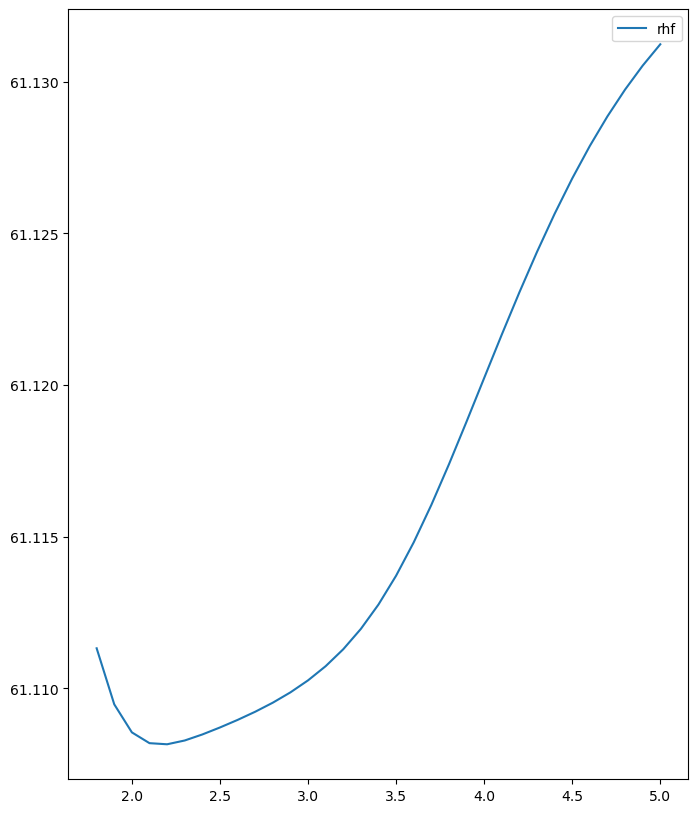

In [209]:
f,ax = plt.subplots(figsize=(8,10))
shift = energies[4,0]-energies[4,1]
ax.plot(bls, energies[:,0]-energies[:,1],label='rhf')
#ax.plot(bls, energies[:,1],label='dhf')
ax.legend()

In [152]:
bls = np.arange(1.0,4.01,0.05)
energies = np.zeros((len(bls),4))
for i in range(len(bls)):
    print(f'Doing {bls[i]}')
    energies[i,:] = dsrg_wrapper(2.0, bls[i])

Doing 1.0
Imaginary part of DSRG-MRPT2 energy, -5.5570600111623795e-09 is larger than 1e-09
Doing 1.05
Imaginary part of DSRG-MRPT2 energy, 1.0485325011925723e-08 is larger than 1e-09
Doing 1.1
Imaginary part of DSRG-MRPT2 energy, -2.4510667463414498e-08 is larger than 1e-09
Doing 1.1500000000000001
Imaginary part of DSRG-MRPT2 energy, -6.798645810133825e-09 is larger than 1e-09
Doing 1.2000000000000002
Imaginary part of DSRG-MRPT2 energy, 1.1445973856516768e-07 is larger than 1e-09
Doing 1.2500000000000002
Imaginary part of DSRG-MRPT2 energy, 2.1793779607969825e-08 is larger than 1e-09
Doing 1.3000000000000003
Imaginary part of DSRG-MRPT2 energy, 2.102209939709582e-07 is larger than 1e-09
Doing 1.3500000000000003
Imaginary part of DSRG-MRPT2 energy, 2.1476313168525836e-07 is larger than 1e-09
Doing 1.4000000000000004
Imaginary part of DSRG-MRPT2 energy, -1.6507654292445594e-07 is larger than 1e-09
Doing 1.4500000000000004
Imaginary part of DSRG-MRPT2 energy, -1.649610095821771e-08 is 

In [161]:
energies[10,0]-energies[10,1]-0.05

29.829536849764008

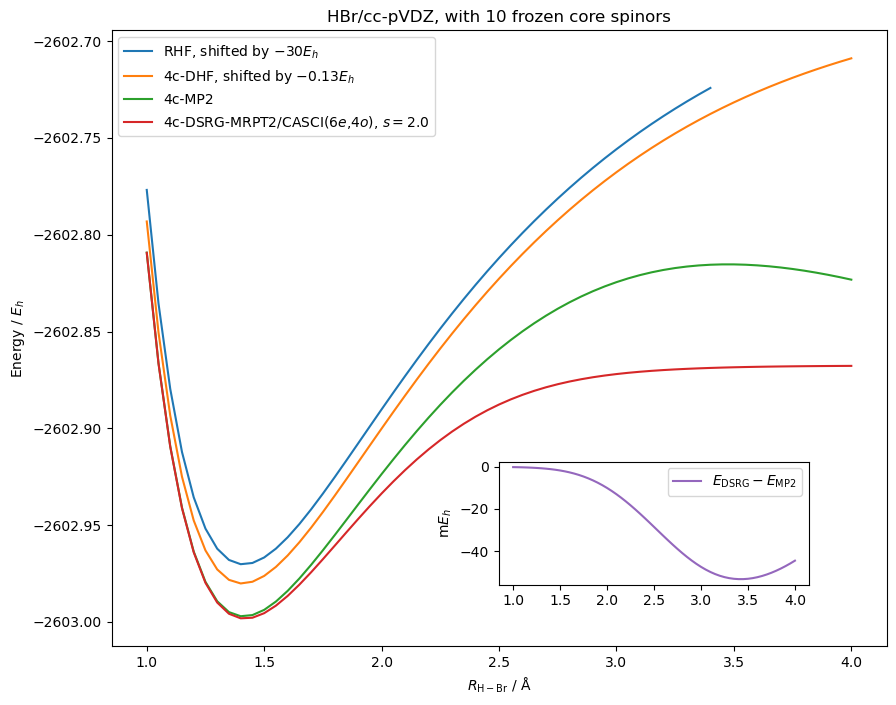

In [195]:
f,ax = plt.subplots(figsize=(10,8))
ax.set_title("HBr/cc-pVDZ, with 10 frozen core spinors")
ax.plot(bls[:-12], energies[:-12,0]-30, label=r'RHF, shifted by $-30E_h$')
ax.plot(bls, energies[:,1]-0.13, label=r'4c-DHF, shifted by $-0.13E_h$')
ax.plot(bls, energies[:,1]+energies[:,2],label='4c-MP2')
ax.plot(bls, energies[:,1]+energies[:,3],label=r'4c-DSRG-MRPT2/CASCI($6e$,$4o$), $s=2.0$')
ax.legend()
ax.set_ylabel(r'Energy / $E_h$')
ax.set_xlabel(r'$R_{\mathrm{H-Br}}$ / $\mathrm{\AA}$')
axins = ax.inset_axes([0.5,0.1,0.4,0.2])
axins.plot(bls, (energies[:,3]-energies[:,2])*1000,label=r'$E_{\mathrm{DSRG}}-E_{\mathrm{MP2}}$',c='tab:purple')
axins.set_ylabel(r'm$E_h$')
axins.legend()
f.savefig('hbr-cc-pvdz.pdf')

In [181]:
np.savetxt('HBr-1.2-4.0-cc-pvdz.dat', energies)

## Full CI limit:

```
Non-relativistic RHF Energy:      -7.8633576 Eh
Relativistic DHF Energy:          -7.8639353 Eh
Rebuilt DHF Energy:               -7.8639353 Eh
Diff:           9.148238e-13
Diff 1e:        7.105427e-15
Diff 2e:        9.086065e-13

Timing report
....integral retrieval:            0.0200372 s
....integral transformation:       0.0036809 s
....integral contractions:         0.0005662 s
Total time taken:                  0.0243838 s

Relativistic MP2 Ecorr:           -0.0121997 Eh
Relativistic MP2 Energy:          -7.8761350 Eh
Time taken:                        0.0010519 s

Time taken for 1-RDM build:        0.2889485 s

Time taken for 2-RDM build:        1.8921976 s

Relativistic CASCI(4,12)
E0:                                -7.8829423 Eh
E0 (from RDM):                     -7.8829423 Eh
Ecorr:                             -0.0190070 Eh

Time taken:                         3.2554252 s
... Hamil build:                    0.9836566 s
... Hamil diag:                     0.0891018 s
... RDM build:                      2.1817663 s
```